In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import requests
import os
from google.colab import userdata

In [2]:
tng_api_key = userdata.get('TNG_API_KEY')
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":tng_api_key}

In [3]:
def get(path, params=None):
    headers = {"api-key":tng_api_key}
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers: #not only json
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [27]:
r = get(baseUrl)

for simulation in r['simulations']: #only get TNG50
    if simulation['name'] == 'TNG50-1':
        url = simulation['url']
        break

tng50 = get(url)

url = 'http://www.tng-project.org/api/TNG50-1/snapshots/z=1.8/'
snapshot = get(url)

sub_url = f"http://www.tng-project.org/api/TNG50-1/snapshots/{snapshot['number']}/subhalos/0/"
subhalo = get(sub_url)

In [35]:
cutout_request = {'gas':'Velocities,Coordinates,InternalEnergy,ElectronAbundance'}
cutout = get(sub_url+"cutout.hdf5", cutout_request)

In [37]:
with h5py.File(cutout,'r') as f:
    x = f['PartType0']['Coordinates'][:,0] - subhalo['pos_x']
    y = f['PartType0']['Coordinates'][:,1] - subhalo['pos_y']
    vel = f['PartType0']['Velocities'][:]
    u = f['PartType0']['InternalEnergy'][:]
    xe = f['PartType0']['ElectronAbundance'][:]

# Calculate the magnitude of the velocities
vel_magnitude = np.sqrt(np.sum(vel**2, axis=1))

Xh = 0.76
mp = 1.67e-27
kb = 1.38e-23
gamma = 5/3
unitRatio = 1e10

mu = 4 / (1 + 3*Xh + 4*Xh*xe) * mp
T = (gamma-1)*unitRatio*mu*u/kb

In [38]:
counts1, bin_edges = np.histogram(T)
counts2, bin_edges = np.histogram(vel_magnitude)

bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

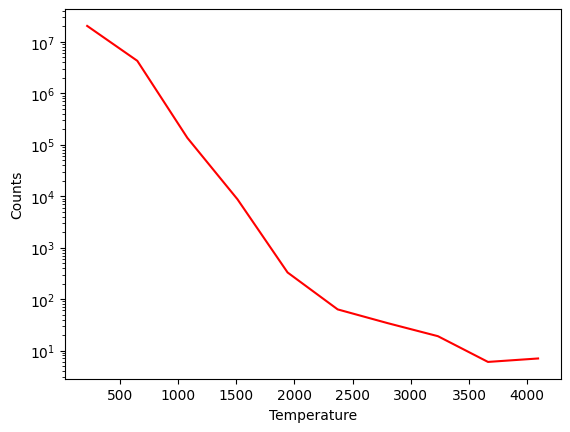

In [39]:
plt.plot(bin_centers, counts1, color="red")
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Temperature')
plt.show()

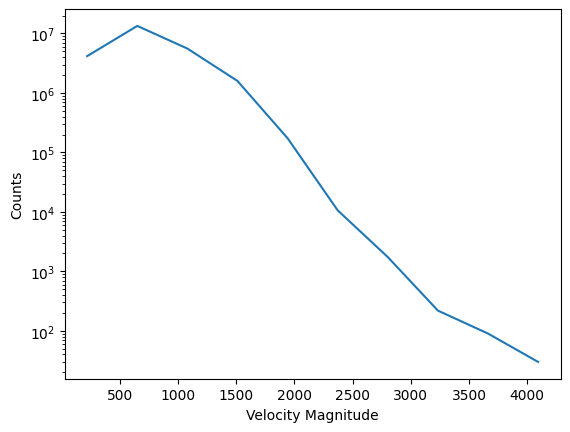

In [40]:
plt.plot(bin_centers, counts2)
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Velocity Magnitude')
plt.show()